In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['OMP_NUM_THREADS'] = '14'
from collections import OrderedDict
import re
from sklearn.mixture import GaussianMixture
from DualGMMFEM import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib import cm


In [2]:
FEM_dict=pd.read_pickle('D:/0210_Phase_II/II_txt2tensor/Outputs/Simple_shear/SH_Set_I_Dict.pkl')
FEM_dict_list=sort_list(list(FEM_dict.keys()))

    
FEM_graph_weights=OrderedDict()
#for model in tqdm(FEM_dict_list):
# Select FEM model
model=FEM_dict_list[0]

In [3]:
#Recap the info of CZEs
SCZEs=FEM_dict[model]['Sets']['STRONG_CZE_CE_ELEMENT_SET'].astype(int)
WCZEs=FEM_dict[model]['Sets']['WEAK_CZE_CE_ELEMENT_SET'].astype(int)
CZEs=np.vstack([SCZEs,WCZEs])
CZEs=CZEs[CZEs[:, 0].argsort()]
Solids=FEM_dict[model]['Sets']['CEMENT_ELEMENT_SET'].astype(int)
temporal_dict=FEM_dict[model]['Time']
#For plots
FEM_frame_nodes=FEM_dict[model]['Time']['T=0']['COORD']
stress=FEM_dict[model]['Time']['T=20']['S'][:,1:]

In [4]:
#Obtain the stress in solid elements
n,_=Solids.shape
sElt=stress[:n,:]

In [5]:
#Obtain the elementary centers
#i=0
eltCenters=[]
for i in range(Solids.shape[0]):
    node_ids=Solids[i,1:]-1
    triangle_vertices=FEM_frame_nodes[node_ids,1:]
    eltCenters.append(triangle_vertices.mean(0))
eltCenters=np.vstack(eltCenters)

In [6]:
fig,ax=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, stress[:,0],titlelabel=[r'Heatmap of $\sigma_{11}$ Component from FEM in MPa', ''])


In [7]:
position_stress=np.hstack([eltCenters,sElt])
stress_idx=0
cluster_target=position_stress[:, [0, 1, stress_idx + 2]]
gmm1,gmm2,labels,idices,final_labels,[vmax,vmin,vscale]=GMM2(cluster_target)

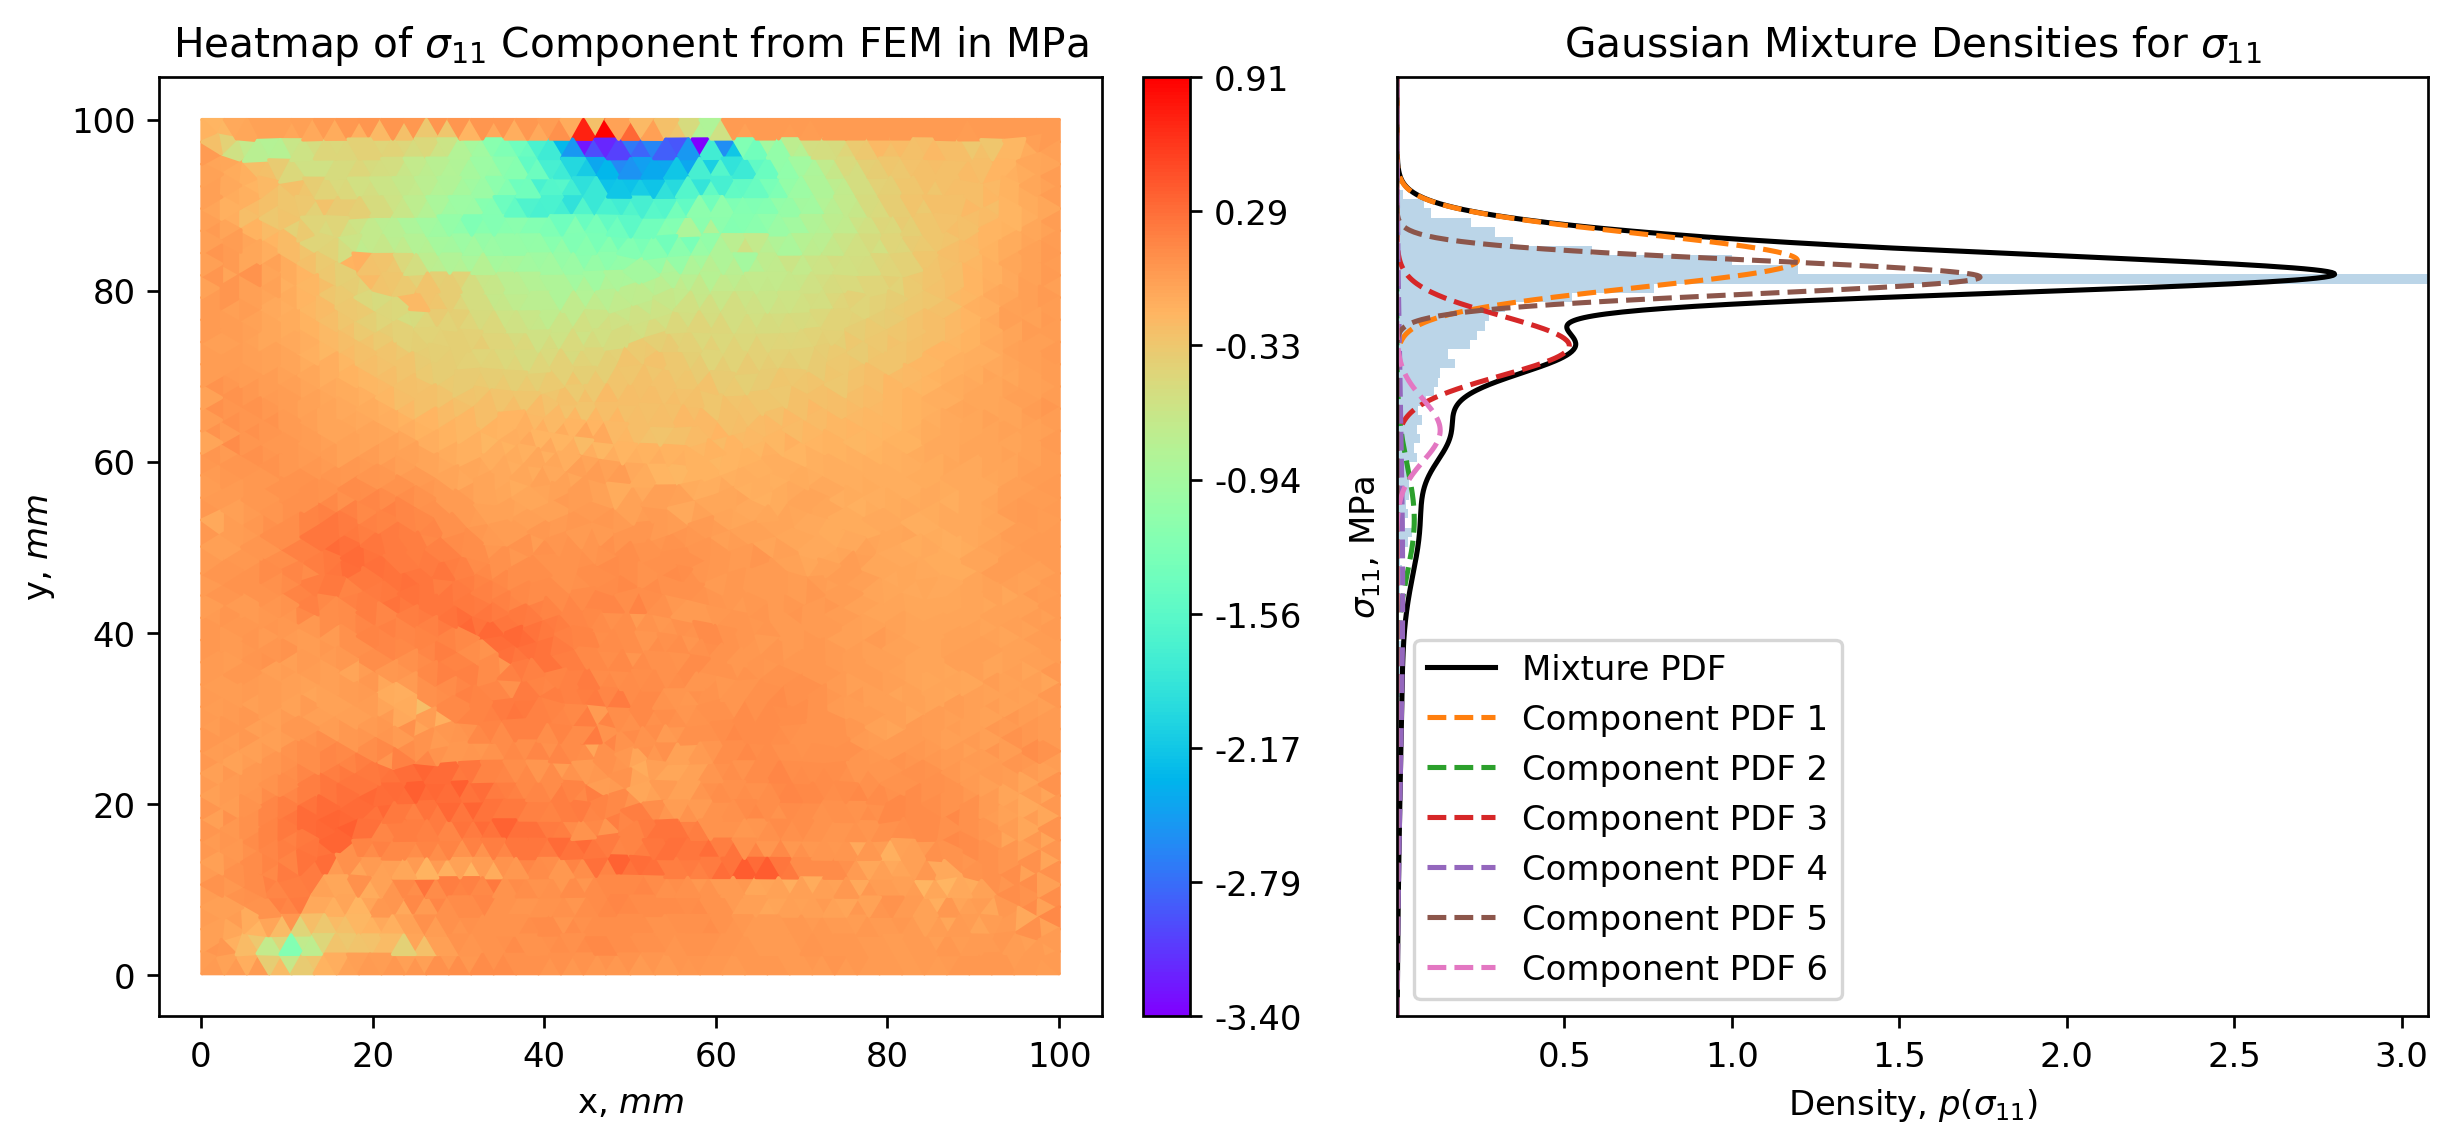

In [8]:
GMM_1D_plot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, stress[:,0], gmm1)

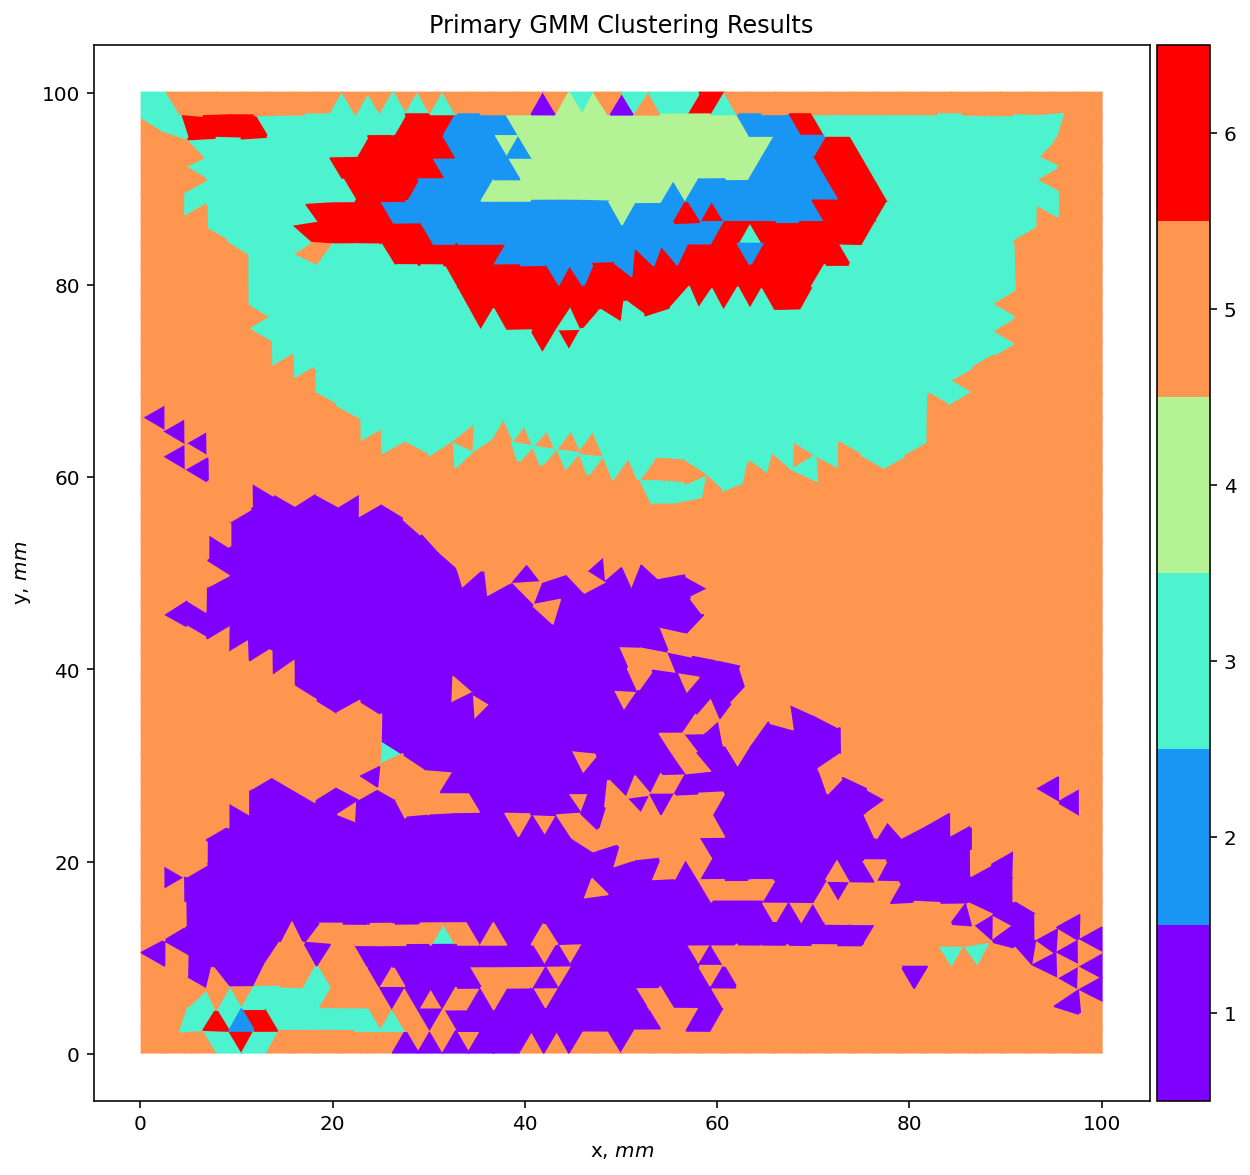

In [9]:
figp1,axp1=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Primary GMM Clustering Results',''],discrete_bar=True)
figp1

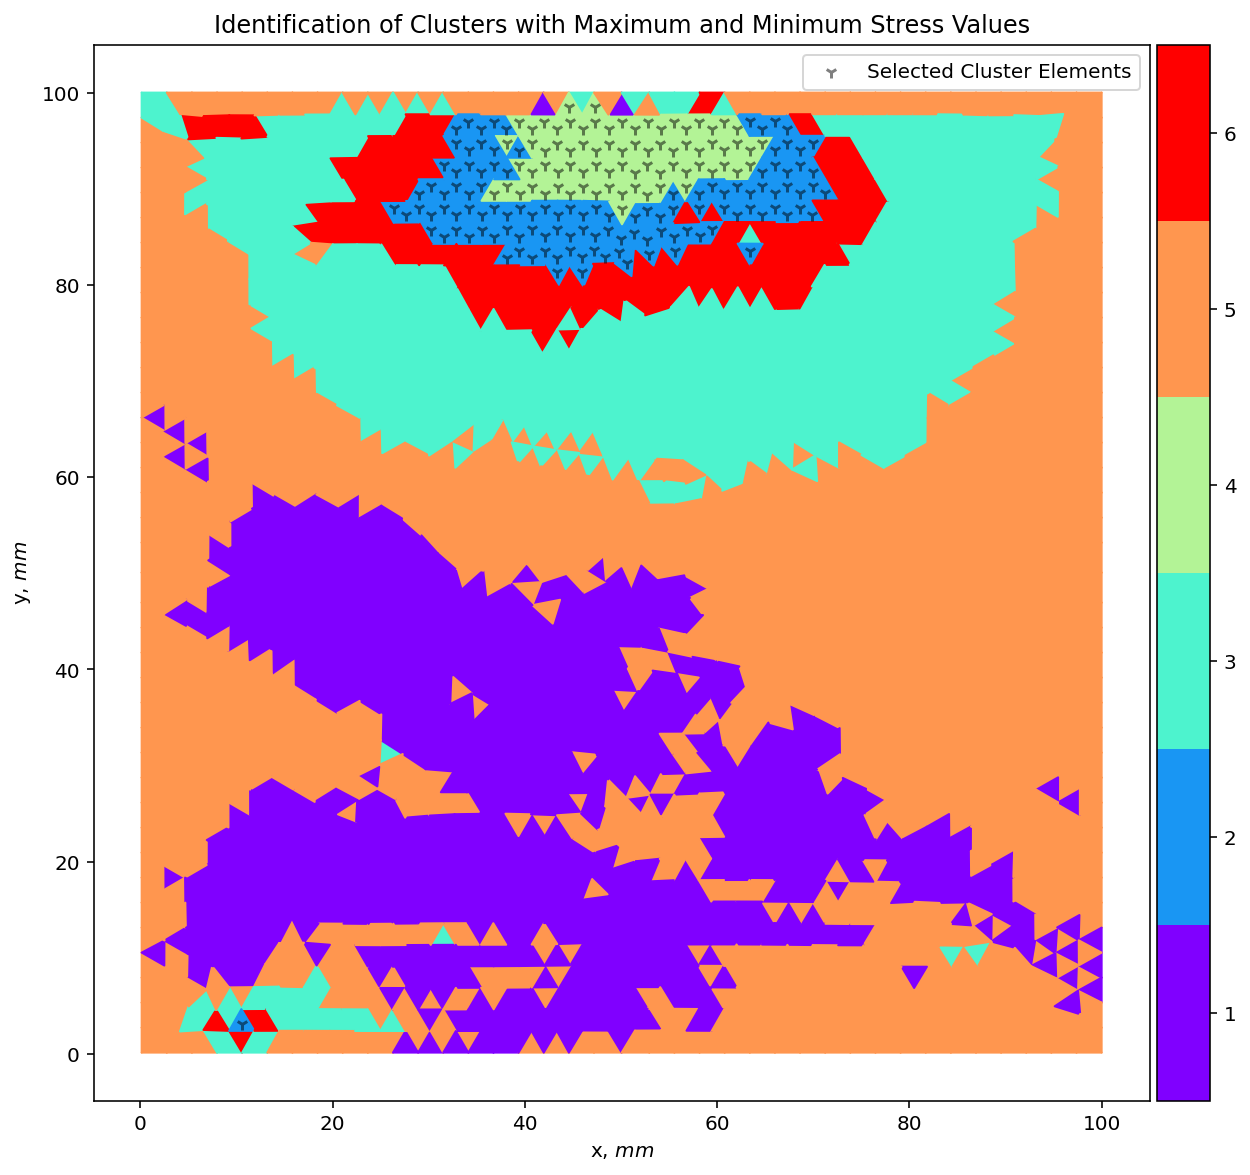

In [10]:
figp1_mark,axp1_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Identification of Clusters with Maximum and Minimum Stress Values',''],discrete_bar=True)
axp1_mark.scatter(eltCenters[idices,0],eltCenters[idices,1],color='k',marker='1',label='Selected Cluster Elements',alpha=0.5)
axp1_mark.legend()
figp1_mark

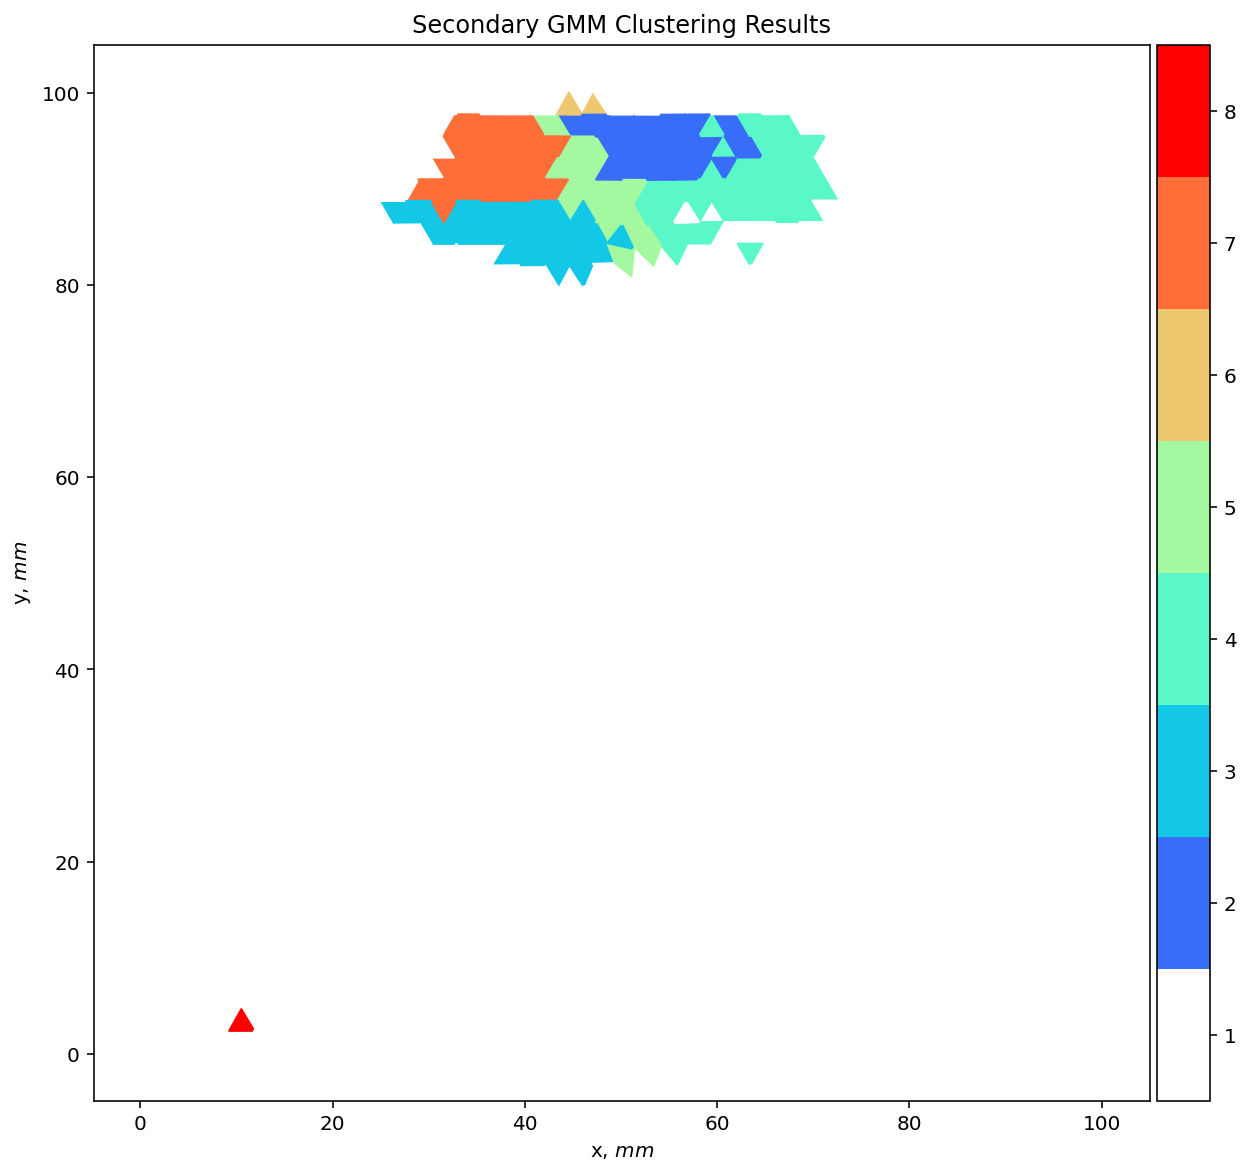

In [11]:
figp2,axp2=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Secondary GMM Clustering Results',''],discrete_bar=True,zero_white=True)
figp2

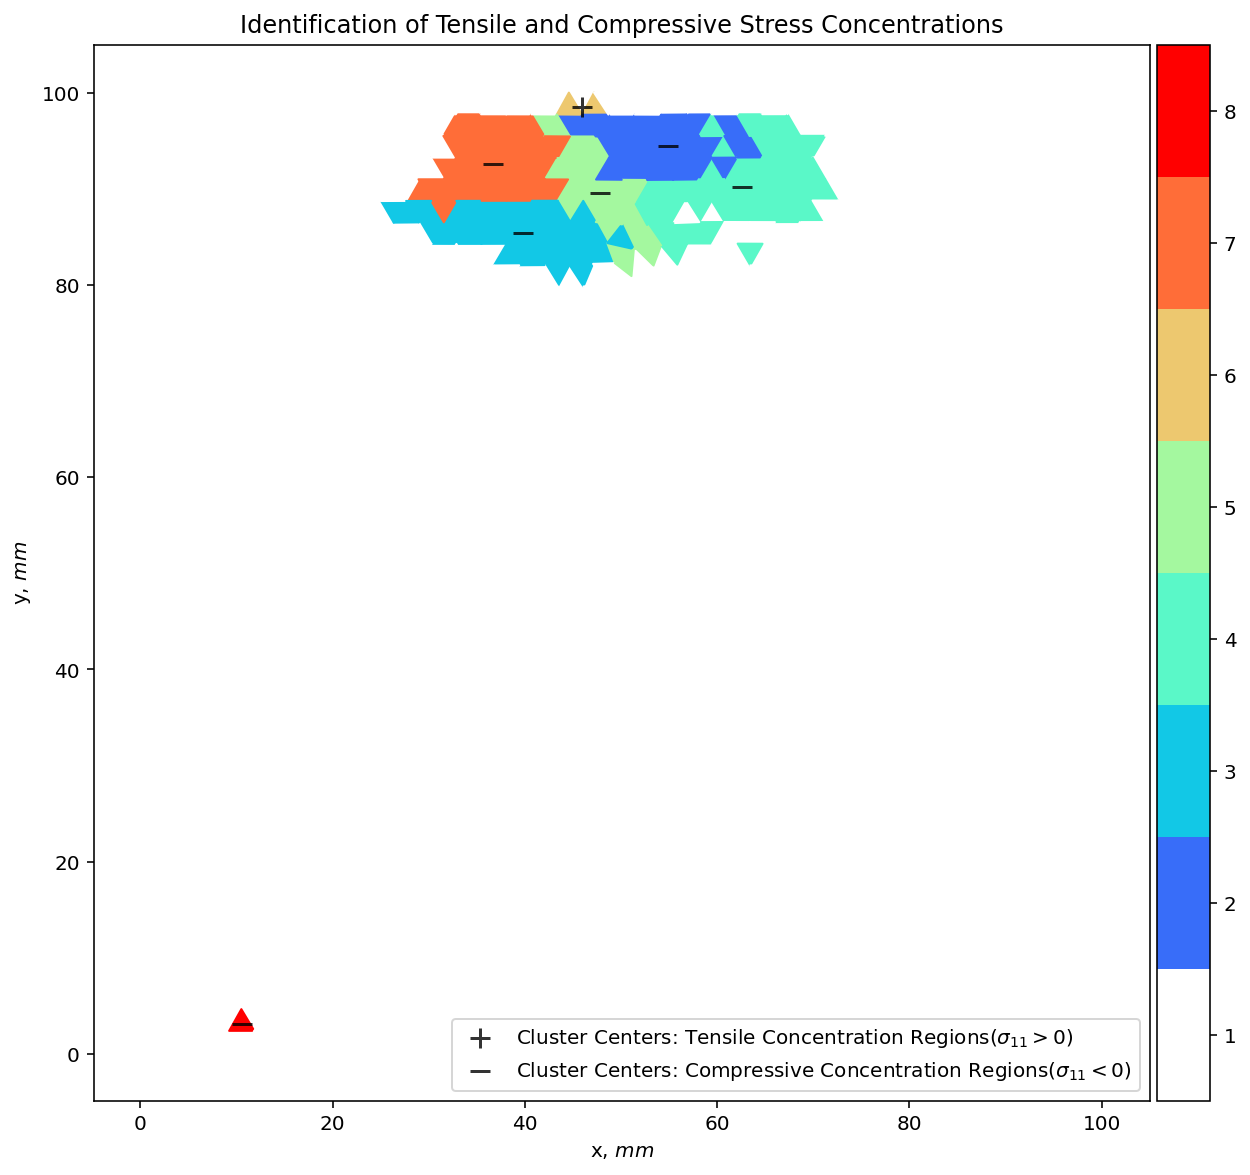

In [12]:
figp2_mark,axp2_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Identification of Tensile and Compressive Stress Concentrations',''],discrete_bar=True,zero_white=True)
retriClusterCenStress=gmm2.means_[:,-1]/vscale*(vmax-vmin)+vmin
axp2_mark.scatter(gmm2.means_[retriClusterCenStress>0,0],gmm2.means_[retriClusterCenStress>0,1],color='k',marker='+',label=r'Cluster Centers: Tensile Concentration Regions$(\sigma_{11}>0)$',alpha=0.8,s=100)
axp2_mark.scatter(gmm2.means_[retriClusterCenStress<0,0],gmm2.means_[retriClusterCenStress<0,1],color='k',marker='_',label=r'Cluster Centers: Compressive Concentration Regions$(\sigma_{11}<0)$',alpha=0.8,s=100)
axp2_mark.legend(loc='lower right')
figp2_mark

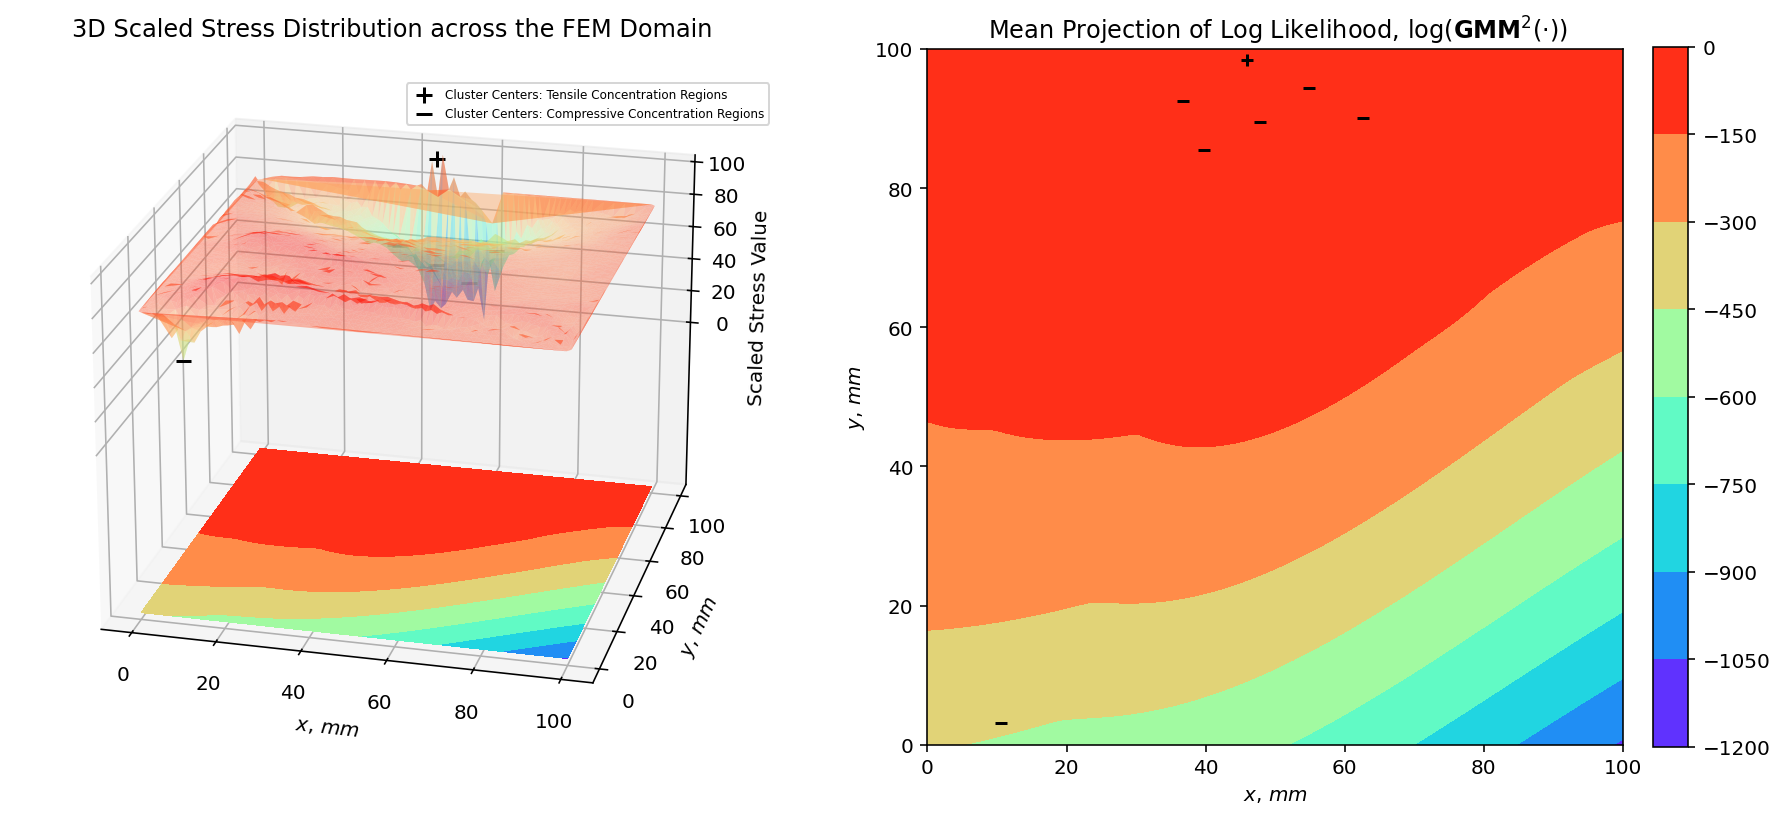

In [13]:
fig3d,Z_score=plot_projectionGMM(cluster_target,gmm2,retriClusterCenStress)
fig3d